# **Introduction to deep learning for computer vision**

### Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yaswanthkumar26","key":"f57b4d39912bf9e0d6a3c238698e2685"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:03<00:00, 250MB/s]
100% 812M/812M [00:03<00:00, 228MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

**Configuring the model for training**

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

# **Training = 8000; Validation = 500; Test = 500**

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [13]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [14]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 8s 31ms/step - loss: 0.7009 - accuracy: 0.5115 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 0.6933 - accuracy: 0.4910 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 0.6915 - accuracy: 0.5200 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 0.6921 - accuracy: 0.5375 - val_loss: 0.6841 - val_accuracy: 0.5030
Epoch 5/20
63/63 [==============================] - 1s 15ms/step - loss: 0.6846 - accuracy: 0.5275 - val_loss: 0.6879 - val_accuracy: 0.5100
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.6803 - accuracy: 0.5615 - val_loss: 0.6798 - val_accuracy: 0.5120
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 0.6754 - accuracy: 0.5765 - val_loss: 0.6664 - val_accuracy: 0.5840
Epoch 8/20
63

**Displaying curves of loss and accuracy during training**

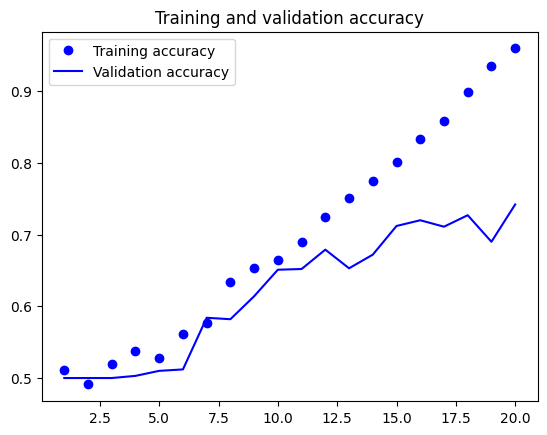

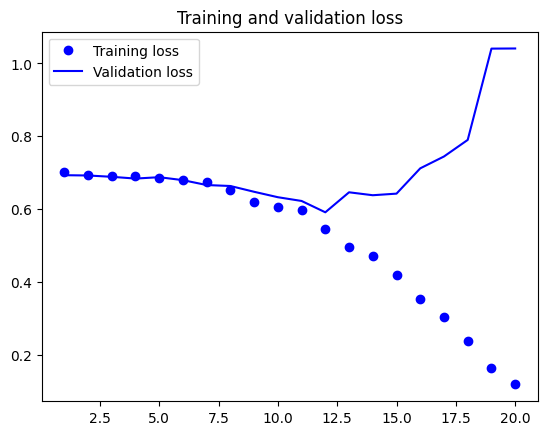

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 7ms/step - loss: 0.6055 - accuracy: 0.6840
Test accuracy: 0.684


# **Using data augmentation**

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# **Displaying some randomly augmented training images**

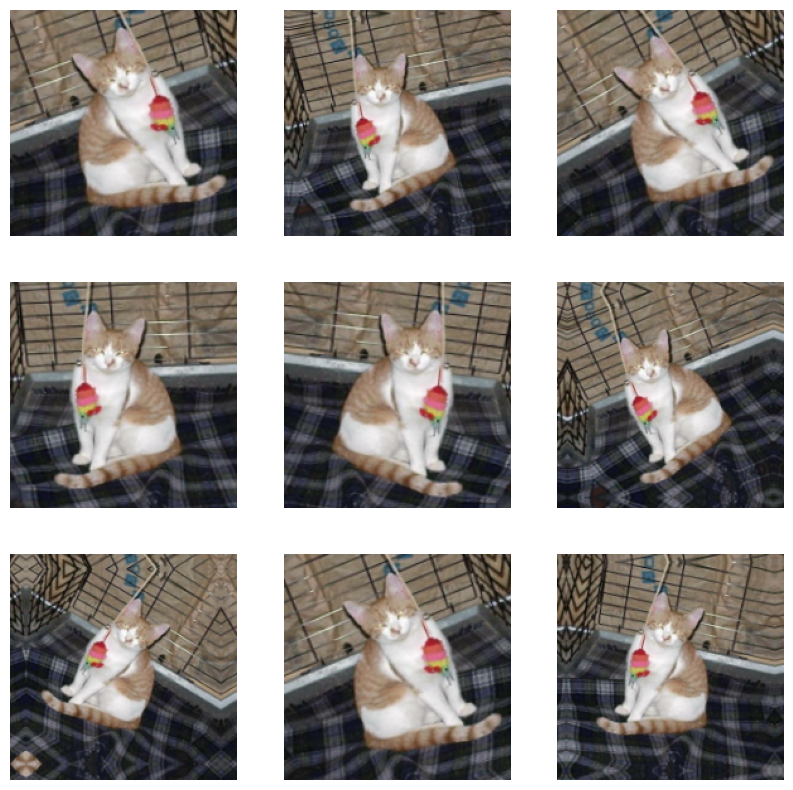

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Defining a new convnet that includes image augmentation and dropout**

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# **Training the regularized convnet**

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 5s 20ms/step - loss: 0.6953 - accuracy: 0.5210 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 1s 18ms/step - loss: 0.6937 - accuracy: 0.4990 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 1s 16ms/step - loss: 0.6936 - accuracy: 0.5195 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 4/10
63/63 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5300 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
63/63 [==============================] - 1s 18ms/step - loss: 0.6928 - accuracy: 0.5140 - val_loss: 0.6909 - val_accuracy: 0.5200
Epoch 6/10
63/63 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5100 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 7/10
63/63 [==============================] - 1s 18ms/step - loss: 0.6922 - accuracy: 0.5260 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 8/10
63

# **Evaluating the model on the test set**

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 7ms/step - loss: 0.6693 - accuracy: 0.5800
Test accuracy: 0.580


# **Leveraging a pretrained model**
Feature extraction with a pretrained model
Instantiating the VGG16 convolutional base


In [24]:

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# **Fast feature extraction without data augmentation**
Extracting the VGG16 features and corresponding labels


In [26]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


In [27]:
train_features.shape

(2000, 5, 5, 512)

# **Defining and training the densely connected classifier**

In [28]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 1s 10ms/step - loss: 8.7448 - accuracy: 0.9300 - val_loss: 3.1570 - val_accuracy: 0.9700
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 2.3457 - accuracy: 0.9840 - val_loss: 3.2134 - val_accuracy: 0.9710
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 1.3471 - accuracy: 0.9890 - val_loss: 5.0333 - val_accuracy: 0.9700
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 0.9932 - accuracy: 0.9895 - val_loss: 6.9399 - val_accuracy: 0.9680
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 0.7757 - accuracy: 0.9905 - val_loss: 6.1256 - val_accuracy: 0.9750
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 0.4983 - accuracy: 0.9960 - val_loss: 6.9514 - val_accuracy: 0.9730
Epoch 7/10
63/63 [==============================] - 0s 5ms/step - loss: 0.6471 - accuracy: 0.9965 - val_loss: 8.4940 - val_accuracy: 0.9640
Epoch 8/10
63/63 [=

# **Plotting the results**

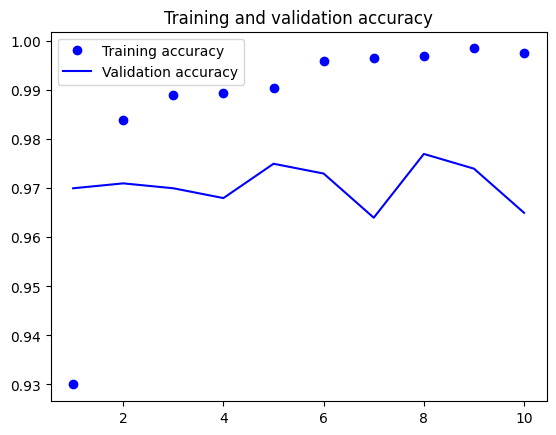

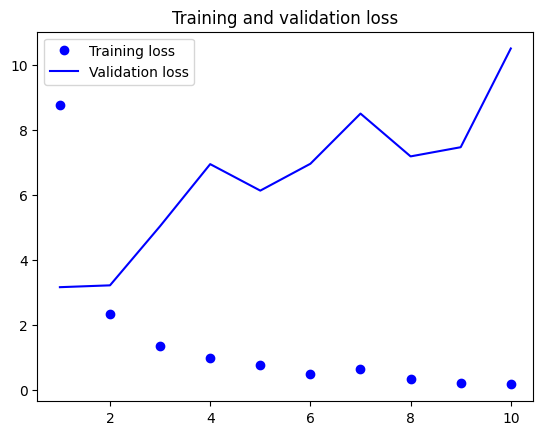

In [29]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Feature extraction together with data augmentation
# Instantiating and freezing the VGG16 convolutional base

In [30]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)


In [31]:
conv_base.trainable = False

# **Printing the list of trainable weights before and after freezing**

In [32]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [33]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


# **Adding a data augmentation stage and a classifier to the convolutional base**

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [35]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_PretrainedIncreasedSample")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

In [36]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [37]:
make_subset("train", start_index=0, end_index=2500)
make_subset("validation", start_index=2500, end_index=3000)
make_subset("test", start_index=3000, end_index=5000)

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


Epoch 1/10
63/63 [==============================] - 1s 9ms/step - loss: 16.4898 - accuracy: 0.9260 - val_loss: 4.5139 - val_accuracy: 0.9590
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 4.0750 - accuracy: 0.9705 - val_loss: 7.5077 - val_accuracy: 0.9650
Epoch 3/10
63/63 [==============================] - 0s 6ms/step - loss: 1.9542 - accuracy: 0.9835 - val_loss: 4.1448 - val_accuracy: 0.9750
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 0.8827 - accuracy: 0.9925 - val_loss: 5.3126 - val_accuracy: 0.9710
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.9935 - val_loss: 4.7852 - val_accuracy: 0.9780
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 0.2157 - accuracy: 0.9950 - val_loss: 5.2853 - val_accuracy: 0.9790
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.9950 - val_loss: 5.9999 - val_accuracy: 0.9760
Epoch 8/10
63/63 [=

# **Evaluating the model on the test set**

In [39]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 5.7715 - accuracy: 0.9655
Test accuracy: 0.965


# **Fine-tuning a pretrained model**

In [40]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# **Freezing all layers until the fourth from the last**

In [41]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_PretrainedoptimalSample")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

In [42]:
conv_base.trainable = True
for layer in conv_base.layers[:-5]:
    layer.trainable = False

In [43]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


# **Fine-tuning the model**

In [44]:
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

# Train the model with varying training sample sizes
sample_sizes = [2700,3000,4500,6000]
history_dict = []
for size in sample_sizes:
    # Set up the training subset
    make_subset("temp_train", start_index=0, end_index=size)
    make_subset("validation", start_index=size, end_index=size+500)
    make_subset("test", start_index=size+500, end_index=size+1500)
    train_dataset = image_dataset_from_directory(
      new_base_dir / "temp_train",
      image_size=(180, 180),
      batch_size=20)
    # Running the callback function to monitor validation loss
    callbacks = [
      keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")]

    # Training the model
    history = model.fit(
      train_features, train_labels,
      epochs=10,
      validation_data=(val_features, val_labels),
      callbacks=callbacks)

Found 5400 files belonging to 2 classes.
Epoch 1/10
63/63 [==============================] - 1s 10ms/step - loss: 21.8186 - accuracy: 0.9155 - val_loss: 3.2780 - val_accuracy: 0.9730
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 3.1877 - accuracy: 0.9735 - val_loss: 3.7014 - val_accuracy: 0.9740
Epoch 3/10
63/63 [==============================] - 0s 4ms/step - loss: 1.1448 - accuracy: 0.9840 - val_loss: 5.8308 - val_accuracy: 0.9660
Epoch 4/10
63/63 [==============================] - 0s 5ms/step - loss: 2.1363 - accuracy: 0.9860 - val_loss: 4.6800 - val_accuracy: 0.9700
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 0.9387 - accuracy: 0.9905 - val_loss: 3.6757 - val_accuracy: 0.9780
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 0.4335 - accuracy: 0.9960 - val_loss: 3.4915 - val_accuracy: 0.9770
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 0.8702 - accuracy: 0.9930 - val_loss: 5.5021 

In [48]:
# Testing the model
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 8.8282 - accuracy: 0.9700
Test accuracy: 0.970


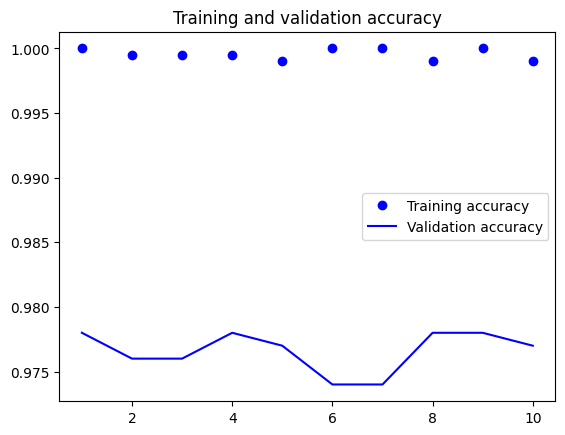

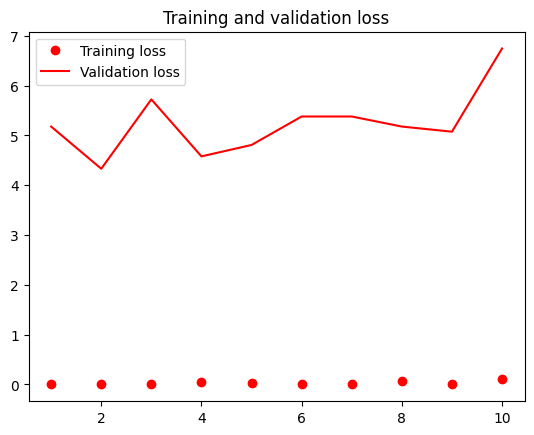

In [49]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()